In [313]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [330]:
'''
Importing California SNG
'''

graph = src.graph.graph_from_json('Outputs/sng_combined_directed.json')

In [331]:
deep_reload(src)

places = [k for k, v in graph._node.items() if v['type'] == 'place']
stations = [k for k, v in graph._node.items() if v['type'] == 'station']

places = src.graph.subgraph(graph, places)
stations = src.graph.subgraph(graph, stations)

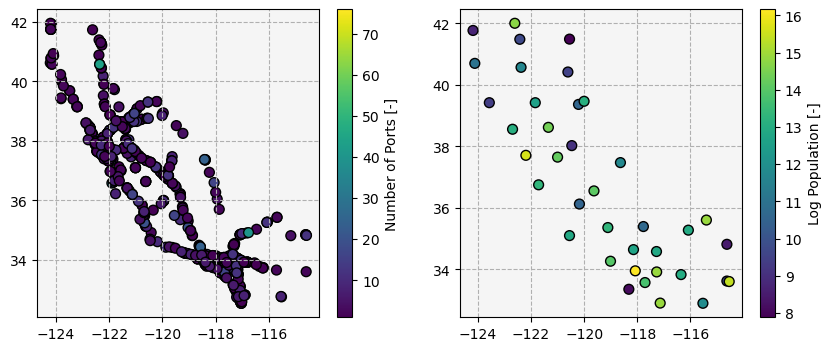

In [332]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

for source, node in places._node.items():

    node['log_population'] = np.log(node['population'])

kw = {
    'show_links': False,
    'node_field': 'log_population',
    'scatter': {
        's': 50,
        'ec': 'k',
        # 'fc': 'none',
        'zorder': 4,
        'label': 'Selected Locations',
    },
    'colorbar': {
        'label': 'Log Population [-]',
    },
}

src.figures.plot_graph(places, ax = ax[1], **kw)

kw = {
    'show_links': False,
    'node_field': 'n_dcfc',
    'scatter': {
        's': 50,
        'ec': 'k',
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': 'Number of Ports [-]',
    },
}

src.figures.plot_graph(
   stations, ax = ax[0], **kw,
)

kw = {
    'facecolor': 'whitesmoke',
}

_ = [ax.set(**kw) for ax in ax]

kw = {
    'ls': '--',
}

_ = [ax.grid(**kw) for ax in ax]

In [345]:
'''
Next step is to define vehicle andsupply station objects.
These objects will be used to add supply costs to edges which begin at a supply station.
'''
deep_reload(src)

seed = 1468952
# seed = None
rng = np.random.default_rng(seed)

risk_attitude = (0, .2)
risk_attitude = (.8, 1)
rho = np.linspace(*risk_attitude, 100)

cases = 30

station_kw = {}

station_kw['place'] = {
    'cases': 1,
    'type': 'ac',
    'access': 'private',
    'price': .4 / 3.6e6,
    'setup_time': 0,
    'rng': rng,
}

station_kw['station'] = {
    'reliability': .5,
    'cases': cases,
    'type': 'dc',
    'access': 'public',
    'power': src.routing._network_power,
    'price': .5 / 3.6e6,
    'setup_time': 300,
    'rng': rng,
}

vehicle_kw = {
    'cases': 1,
    'linear_fraction': .8,
    'risk_attitude': (0, 1),
    # 'max_charge_start_soc': .8,
}

vehicle = src.routing.Vehicle(**vehicle_kw)

graph = src.routing.supply_costs(graph, vehicle, station_kw)

In [346]:
deep_reload(src)

# vehicle_kw['max_charge_start_soc'] = .5
# vehicle = src.routing.Vehicle(**vehicle_kw)

destinations = [k for k, v in graph._node.items() if v['type'] == 'place']
origins = [destinations[0]]

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, origins, objective = vehicle, destinations = destinations,
    terminate_at_destinations = True,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 1.4322 seconds


In [347]:
len(costs)

38

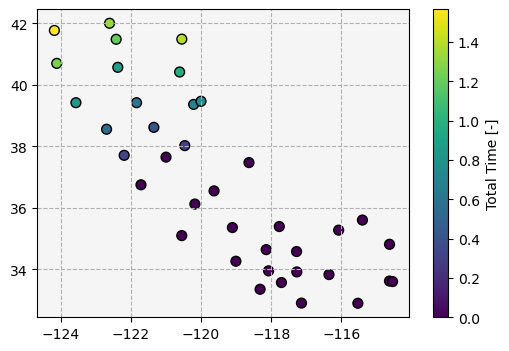

In [348]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

for source, node in places._node.items():

    node['plot'] = (
        values[source]['total_time'].mean() - 
        values[source]['driving_time'].mean()
    )/ 3600

kw = {
    'show_links': False,
    'node_field': 'plot',
    'scatter': {
        's': 50,
        'ec': 'k',
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': 'Total Time [-]',
    },
}

src.figures.plot_graph(
   places, ax = ax, **kw,
)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

In [349]:
deep_reload(src)

origins = [k for k, v in graph._node.items() if v['type'] == 'place']

t0 = time.time()

costs, values, paths = src.routing.all_pairs_shortest_paths(
    graph, origins, objective = vehicle,
)

print(f'\n\nExecuted in {time.time() - t0:.4f} seconds')

 [------------>] (38/38) 100.00%, 0.71 it/s, 54.81 s elapsed, 0.00 s remaining

Executed in 54.8105 seconds


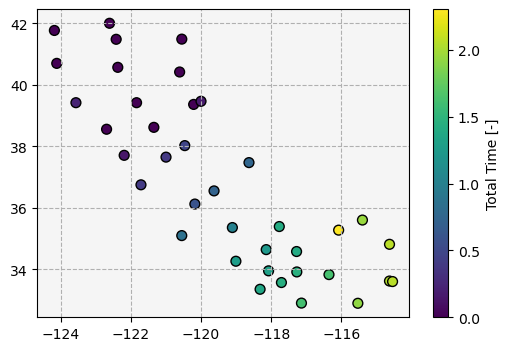

In [360]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

for source, node in places._node.items():

    node['plot'] = (
        values['Portland (State Line)'][source]['total_time'].mean() - 
        values['Portland (State Line)'][source]['driving_time'].mean()
    )/ 3600

kw = {
    'show_links': False,
    'node_field': 'plot',
    'scatter': {
        's': 50,
        'ec': 'k',
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': 'Total Time [-]',
    },
}

src.figures.plot_graph(
   places, ax = ax, **kw,
)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

In [353]:
cities = src.graph.graph_from_json('Outputs/places.json')

pop_adj = sum([v['population'] for v in cities._node.values()]) / cities.number_of_nodes()

weighted = {k: v['population'] / pop_adj for k, v in cities._node.items()}

In [354]:
src.routing.impedance(values, field = 'total_time') / 3600

6.41760677419075

In [355]:
src.routing.impedance(
    values, field = 'total_time',
    origins = weighted,
    destinations = weighted,
) / 3600

4.936471350591397

In [361]:
'''
Importing California SNG
'''

graph = src.graph.graph_from_json('Outputs/sng_other_directed.json')

In [374]:
deep_reload(src)

seed = 1468952
seed = None
rng = np.random.default_rng(seed)

vehicle_param = src.experiments._vehicle_kwargs
station_param = src.experiments._station_kwargs
graphs = [0]

graph_index, vehicle_kw, station_kw = src.experiments.generate_case(
    graphs, vehicle_param, station_param, rng,
)

graph_index, vehicle_kw, station_kw

(0,
 {'capacity': 428160540.29946417,
  'power': 105285.74096479538,
  'risk_attitude': array([0.1550787, 0.3550787]),
  'cases': 1,
  'soc_bounds': (0.1, 1),
  'efficiency': 550,
  'linear_fraction': 0.8},
 {'place': {'cases': 100,
   'type': 'ac',
   'access': 'private',
   'price': 1.1111111111111112e-07,
   'setup_time': 0,
   'rng': Generator(PCG64) at 0x7F47114FBD80},
  'station': {'reliability': 0.6191481485028205,
   'cases': 100,
   'type': 'dc',
   'access': 'public',
   'power': {'Tesla': [250000.0],
    'Electrify America': [150000.0],
    'ChargePoint Network': [62500.0],
    'eVgo Network': [50000.0, 100000.0, 350000.0],
    'default': [50000.0]},
   'price': 1.3888888888888888e-07,
   'setup_time': 300,
   'rng': Generator(PCG64) at 0x7F47114FBD80}})

In [386]:
deep_reload(src)

t0 = time.time()

costs, values, paths = src.experiments.run_case(
    graph, vehicle_kw, station_kw, method = 'dijkstra'
)

print(f'\n\nExecuted in {time.time() - t0:.4f} seconds')



Executed in 17.4028 seconds


In [384]:
src.routing.impedance(
    values, field = 'total_time',
    origins = weighted,
    destinations = weighted,
) / 3600

7.075957469149

In [385]:
src.routing.impedance(
    values, field = 'routing_time',
    # origins = weighted,
    # destinations = weighted,
) / 3600

9.339902910516752

In [142]:
src.routing.impedance(
    values, field = 'total_time',
    origins = weighted,
    destinations = weighted,
) / 3600

7.704711236725918

In [143]:
src.routing.impedance(
    values, field = 'routing_time',
    origins = weighted,
    destinations = weighted,
) / 3600

6.101005247252591